In [1]:
# Imported Modules
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
# Extracts video frames
def get_frames(video, frame_interval):
    '''Extracts one frame every `frame_interval` frames from the video.'''
    cap = cv2.VideoCapture(video)
    all_frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_num = 0

    while frame_num < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        all_frames.append(frame)
        frame_num += frame_interval
    
    return all_frames

# Get a frame every 10 seconds
frame_interval = 500
all_frames1 = get_frames("Scrabble Game 1.mp4", frame_interval)
# all_frames2 = get_frames("Scrabble Game 2.mp4", frame_interval)
# all_frames3 = get_frames("Scrabble Game 3.mp4", frame_interval)

In [3]:
# Isolates board
def filter_background(im):
    '''Filters the background leaving just the board'''
    im_filtered = im.copy()
    lower_blue = np.array([0, 0, 0])
    upper_blue = np.array([80, 255, 255])
    mask = cv2.inRange(im, lower_blue, upper_blue)
    im_filtered[(mask == 0),:] = (0,0,0)

    return im_filtered

def find_largest_contour(im_filtered):
    '''Find the largest contour in the image which will be the board'''

    # Change image to grayscale and threshold for best results
    im_gray = cv2.cvtColor(im_filtered, cv2.COLOR_RGB2GRAY)
    thresh_val_used, thresh_im = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh_im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Biggest contour will be board
    largest_contour = max(contours, key = cv2.contourArea)

    return largest_contour

def find_corners(largest_contour):
    '''Finds corners of board'''

    # Find corners of board
    epsilon = 0.04*cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)
    corners = corners.reshape(-1, 2)
    corners = np.unique(corners, axis = 0)  # Sometimes poly function finds more than 4 corners
    
    # Rearrange to match reference data
    rearranged_corners = np.zeros((4,2), dtype = int)
    s = corners.sum(axis = 1)
    rearranged_corners[0] = corners[np.argmin(s)]     # Top left
    rearranged_corners[3] = corners[np.argmax(s)]     # Bottom right
    diff = np.diff(corners, axis = 1)
    rearranged_corners[1] = corners[np.argmin(diff)]  # Top right
    rearranged_corners[2] = corners[np.argmax(diff)]  # Bottom left

    return rearranged_corners

def generate_warped_board(im, corners):
    '''Uses the corners to generate a warped 800x800 image of the board'''
    
    # Changing corners order to work best with functions
    corners = corners[[0, 1, 3, 2], :]
    corners = corners.astype(np.float32)
    transfer_size = np.array([[0, 0], [800, 0], [800, 800], [0, 800]], dtype = np.float32)

    # Generating warped perspective
    M = cv2.getPerspectiveTransform(corners, transfer_size)
    warped = cv2.warpPerspective(im, M, (800, 800))

    return warped

def get_scrabble_board(all_frames):
    '''Isolates the scrabble board from the frames'''
    all_im = []
    all_im_filtered = []
    all_warped = []
    for i in range(len(all_frames)):
        im = cv2.cvtColor(all_frames[i], cv2.COLOR_BGR2RGB)
        im_filtered = filter_background(im)
        largest_contour = find_largest_contour(im_filtered)
        rearranged_corners = find_corners(largest_contour)
        warped = generate_warped_board(im, rearranged_corners)

        all_im.append(im)
        all_im_filtered.append(im_filtered)
        all_warped.append(warped)

    return all_im, all_im_filtered, all_warped  

# Get scrabble board data
all_im1, all_im_filtered1, all_warped1 = get_scrabble_board(all_frames1)
# all_im2, all_im_filtered2, all_warped2 = get_scrabble_board(all_frames2)
# all_im3, all_im_filtered3, all_warped3 = get_scrabble_board(all_frames3)

# # Show all frames for game 1
# for i in range(len(all_warped1)):
#     plt.imshow(all_warped1[i])
#     plt.axis("off")
#     plt.show()

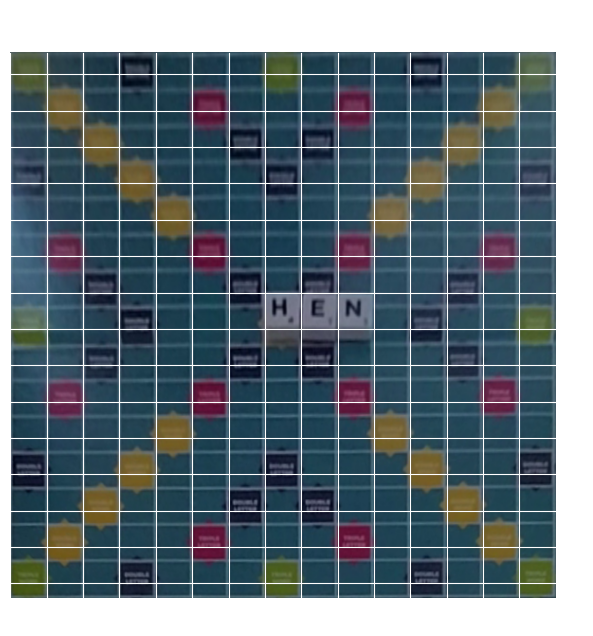

C:\Users\liamj\AppData\Local\Temp\ipykernel_6532\3614833956.py:130: RuntimeWarning: invalid value encountered in scalar divide
  white_grid[i, j] = white_pixels/total_pixels
C:\Users\liamj\AppData\Local\Temp\ipykernel_6532\3614833956.py:131: RuntimeWarning: invalid value encountered in scalar divide
  black_grid[i, j] = black_pixels/total_pixels


In [4]:
def find_board_corner(g, corner):

    if corner == 'Top Left' or corner == 'Top Right' or corner == 'Bottom Left':
        p82 = np.percentile(g, 82)
        g[g < p82] = 0
    elif corner == 'Bottom Right':
        p94 = np.percentile(g, 94)
        g[g < p94] = 0

    # Find contours of bright regions
    contours, _ = cv2.findContours(g, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)  # bounding rectangle

    # plt.figure()
    # plt.imshow(g, 'gray') 
    if corner == 'Top Left':
        corner_points = np.array((x, y))
        # plt.scatter(corner_points[0], corner_points[1])
    elif corner == 'Top Right':
        corner_points = np.array((x+w+700, y))
        # plt.scatter(corner_points[0] - 700, corner_points[1])
    elif corner == 'Bottom Left':
        corner_points = np.array((x, y+h+700))
        # plt.scatter(corner_points[0], corner_points[1] - 700)
    elif corner == 'Bottom Right':
        corner_points = np.array((x+w+700, y+h+700))
    #     plt.scatter(corner_points[0] - 700, corner_points[1] - 700)
    
    # plt.axis("off")
    # plt.show()

    return corner_points

def generate_warped_board2(im, corners):
    '''Uses the corners to generate a warped 750x750 image of the board'''
    
    # Changing corners order to work best with functions
    corners = corners[[0, 1, 3, 2], :]
    corners = corners.astype(np.float32)
    transfer_size = np.array([[0, 0], [750, 0], [750, 750], [0, 750]], dtype = np.float32)

    # Generating warped perspective
    M = cv2.getPerspectiveTransform(corners, transfer_size)
    warped = cv2.warpPerspective(im, M, (750, 750))

    return warped

# for frame_chooser in range(len(all_warped1)):
for frame_chooser in range(1):
    frame_chooser = 3
    img = all_warped1[frame_chooser]
    kernel_close = np.ones((20,20), np.uint8) 
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close) 

    kernel_open = np.ones((5,5), np.uint8) 
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open) 

    gray_full = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    strip = 100 
    top_left_gray = gray_full[0:strip,0:strip] 
    top_right_gray = gray_full[0:strip,-strip:-1]
    bottom_left_gray = gray_full[-strip:-1,0:strip] 
    bottom_right_gray = gray_full[-strip:-1,-strip:-1] 

    top_left_corner = find_board_corner(top_left_gray, 'Top Left')
    top_right_corner = find_board_corner(top_right_gray, 'Top Right')
    bottom_left_corner = find_board_corner(bottom_left_gray, 'Bottom Left')
    bottom_right_corner = find_board_corner(bottom_right_gray, 'Bottom Right')

    # plt.figure()
    # plt.imshow(gray_full, 'gray') 
    # plt.scatter(top_left_corner[0], top_left_corner[1])
    # plt.scatter(top_right_corner[0], top_right_corner[1])
    # plt.scatter(bottom_left_corner[0], bottom_left_corner[1])
    # plt.scatter(bottom_right_corner[0], bottom_right_corner[1])
    # plt.axis("off")
    # plt.show()

    corners = np.array((top_left_corner, top_right_corner, bottom_left_corner, bottom_right_corner))
    warped_board2 = generate_warped_board2(all_warped1[frame_chooser], corners)

    # Image size and grid dimensions
    board_size = 750
    num_squares = 15
    cell_size = board_size/num_squares  # 50 pixels

    # Generate coordinates for the grid lines
    x = np.linspace(0, board_size, num_squares + 1)
    y = np.linspace(0, board_size, num_squares + 1) - 20
    X, Y = np.meshgrid(x, y)

    # Plot the warped board
    plt.figure(figsize=(8, 8))
    plt.imshow(warped_board2)
    plt.axis("off")

    # Draw grid lines
    for i in range(num_squares + 1):
        plt.plot([x[i], x[i]], [0, board_size], color='white', linewidth=0.8)  # vertical
        plt.plot([0, board_size], [y[i], y[i]], color='white', linewidth=0.8)  # horizontal

    plt.axis("off")
    plt.savefig('Full board.png')
    plt.show()

    def get_black_white_proportion_grid(warped_board, num_squares=15, white_thresh=120, black_thresh=20):
        """
        Compute the proportion of near-white and near-black pixels in each cell of a warped board.
        Returns two 15x15 numpy arrays: white_proportion_grid, black_proportion_grid.
        """
        gray = cv2.cvtColor(warped_board, cv2.COLOR_BGR2GRAY)
        board_size = gray.shape[0]
        cell_size = board_size//num_squares

        white_grid = np.zeros((num_squares, num_squares), dtype=float)
        black_grid = np.zeros((num_squares, num_squares), dtype=float)

        letter_mat = np.zeros((15,15))
        for i in range(num_squares):
            for j in range(num_squares):
                y1, y2 = i*cell_size, (i + 1)*cell_size
                x1, x2 = j*cell_size, (j + 1)*cell_size
                cell = gray[y1-20:y2-20, x1:x2]

                total_pixels = cell.size
                white_pixels = np.sum(cell >= white_thresh)
                black_pixels = np.sum(cell <= black_thresh)

                white_grid[i, j] = white_pixels/total_pixels
                black_grid[i, j] = black_pixels/total_pixels

                if white_grid[i,j] + black_grid[i,j] > 0.7:
                    # Detection method
                    a = 1

        return white_grid + black_grid

    letter_mat = get_black_white_proportion_grid(warped_board2, num_squares=15, white_thresh=100, black_thresh=50)

    # plt.figure(figsize=(6,6))
    # plt.imshow(white_black_grid, cmap='hot', interpolation='nearest')
    # plt.colorbar(label="Proportion of white pixels")
    # plt.title("White Proportion per Scrabble Cell")
    # plt.show()